In [2]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from sklearn.metrics import classification_report


Preproccesing Functions

In [5]:
# Band pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

Define the dataset

In [27]:
# Define the column names
import matplotlib.pyplot as plt
# folder_name = input("Please enter the subject name: ")

folder_name='f'
column_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ',
                'Battery', 'Sample', 'Unknown', 'Instruction', 'Female/Male', 'Outdoor/Indoor', 'Human Behavior']

selected_columns=['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
raw = []
event=[]
bandpass=[]
denoised=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst=s_temp.iloc[:, 17]
            df_temp=s_temp.iloc[:, :8]
            raw.append(df_temp)
            event.append(inst)
            # print(df_temp.shape) # (10000, 8)
            
            #preprocess
            raw_eeg_bp = np.copy(df_temp)
            for column in range(df_temp.shape[1]):
                raw_eeg_bp[:, column] = butter_bandpass_filter(raw_eeg_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            bandpass.append(raw_eeg_bp) 
            
            eeg_df_denoised = preprocess(pd.DataFrame(raw_eeg_bp, columns=selected_columns), col_names=selected_columns, n_clusters=[50]*len(selected_columns))    
            denoised.append(eeg_df_denoised)
            
            # for i in range(8):
            #     fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
            #     axs[0].plot(df_temp.iloc[:,i])
            #     axs[0].set_title(f'Original data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[1].plot(raw_eeg_bp[:,i])
            #     axs[1].set_title(f'Filtered data of block {file_name.replace(".csv", "")} column {i}')
            #     axs[2].plot(eeg_df_denoised.iloc[:,i])
            #     axs[2].set_title(f'Denoised data of block {file_name.replace(".csv", "")} column {i}')
            #     plt.tight_layout()  # Adjusts subplot parameters for better fit
            #     plt.show()

In [28]:
event=np.array(event).reshape(40*10000, 1)
raw=np.array(raw).reshape(40*10000, 8)   
bandpass=np.array(bandpass).reshape(40*10000, 8)   
denoised=np.array(denoised).reshape(40*10000, 8)   
pp_sig_event=np.concatenate((denoised, event), axis=1)

labels=[] 
face = [] #lable=0
scene=[]#lable=1
for i in range(len(pp_sig_event)):
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)
        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels)     
             
print('event', event.shape, 'raw', raw.shape, 'bandpass', bandpass.shape, 'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)          

event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)


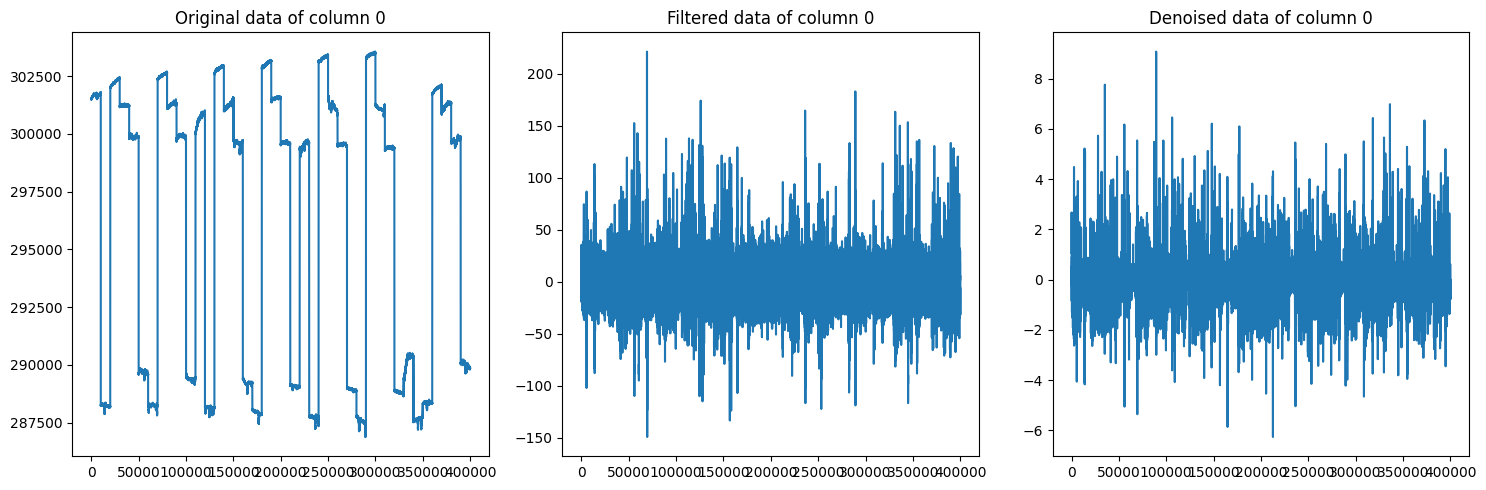

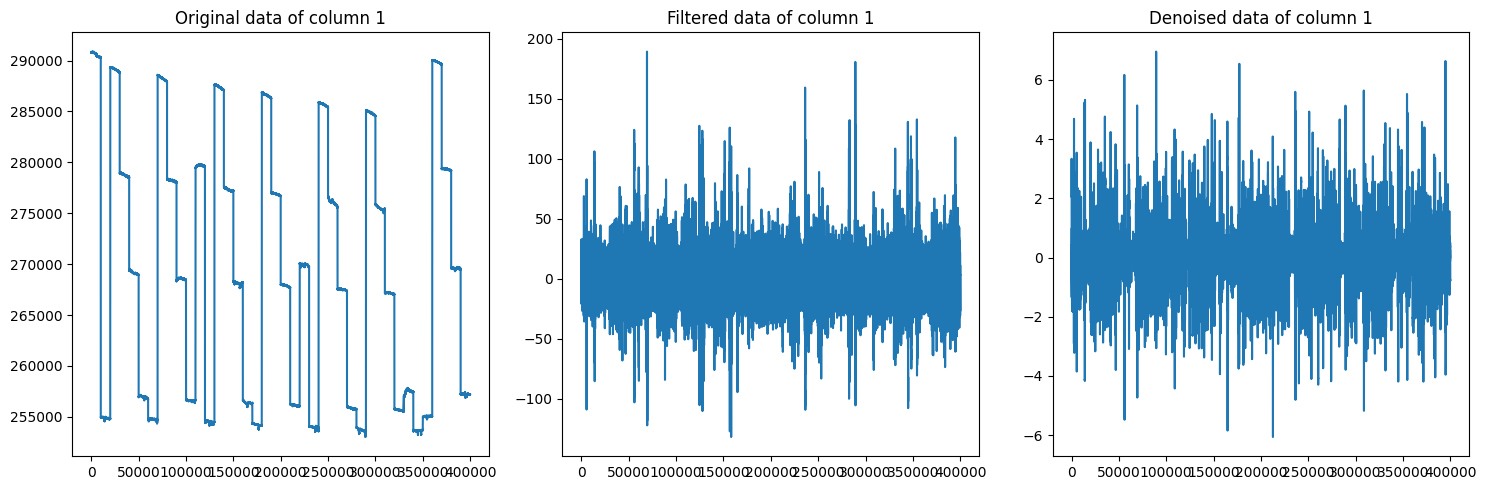

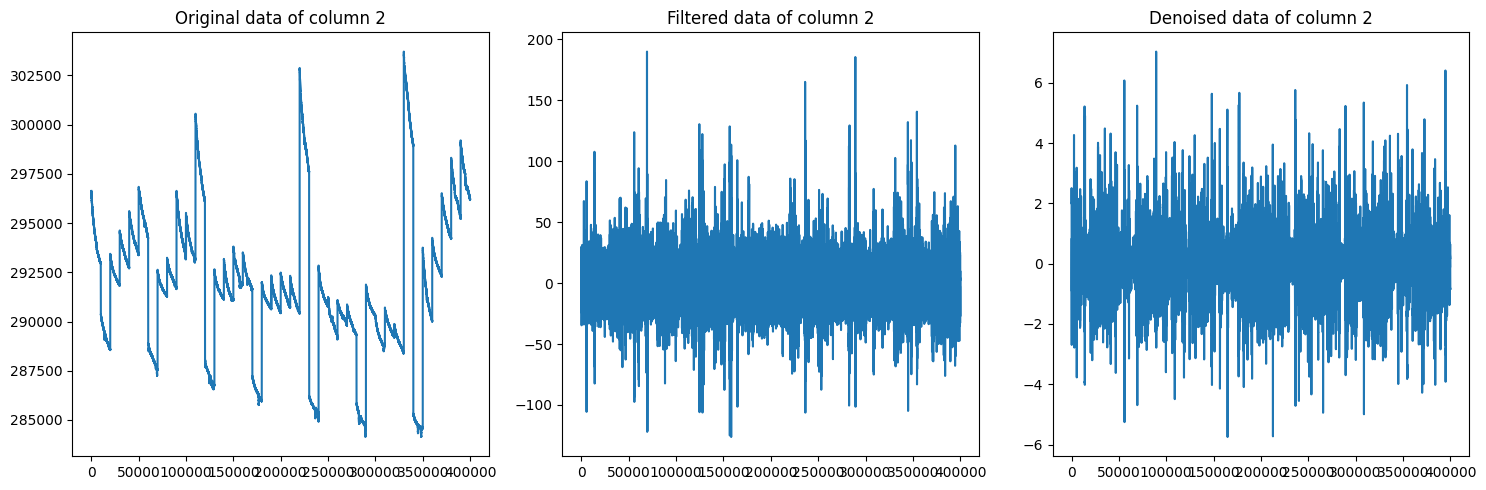

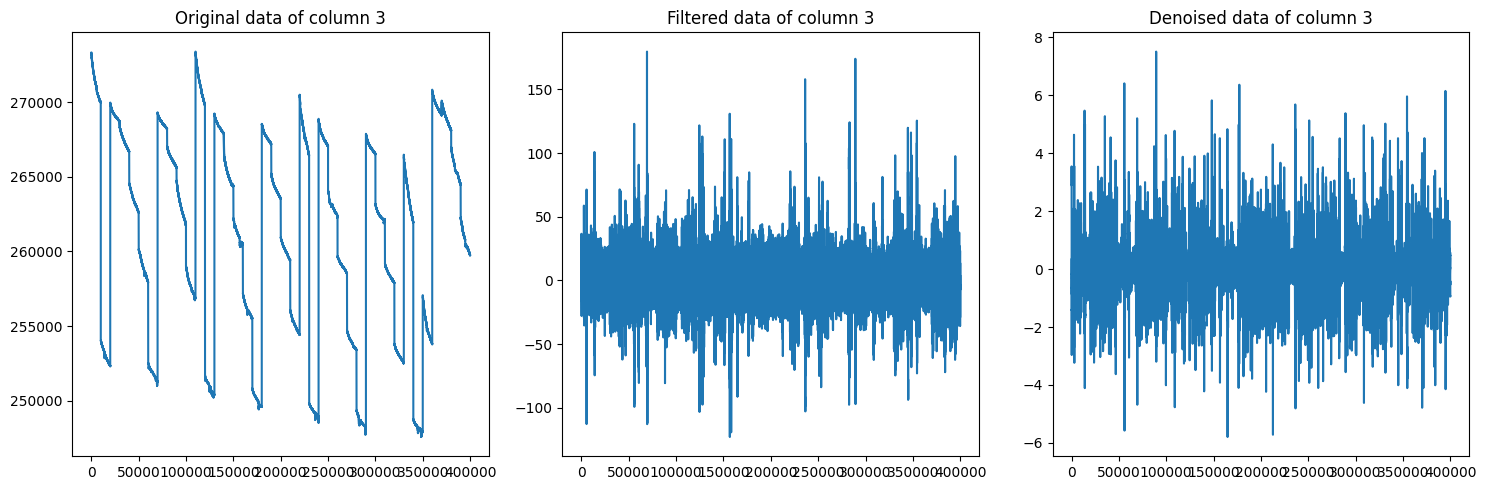

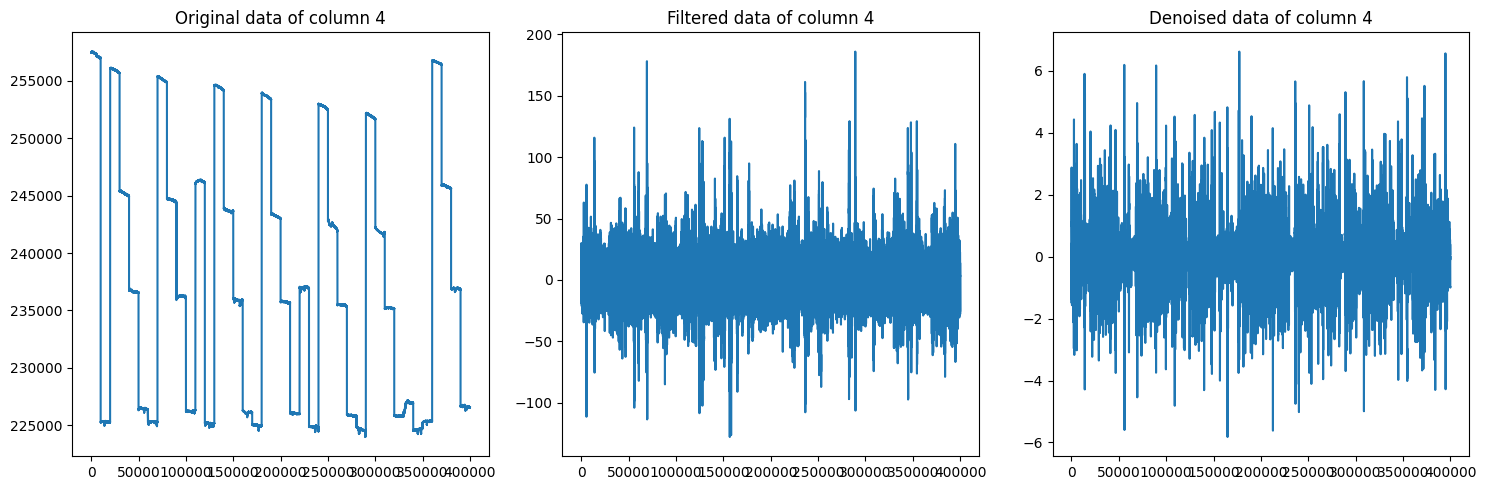

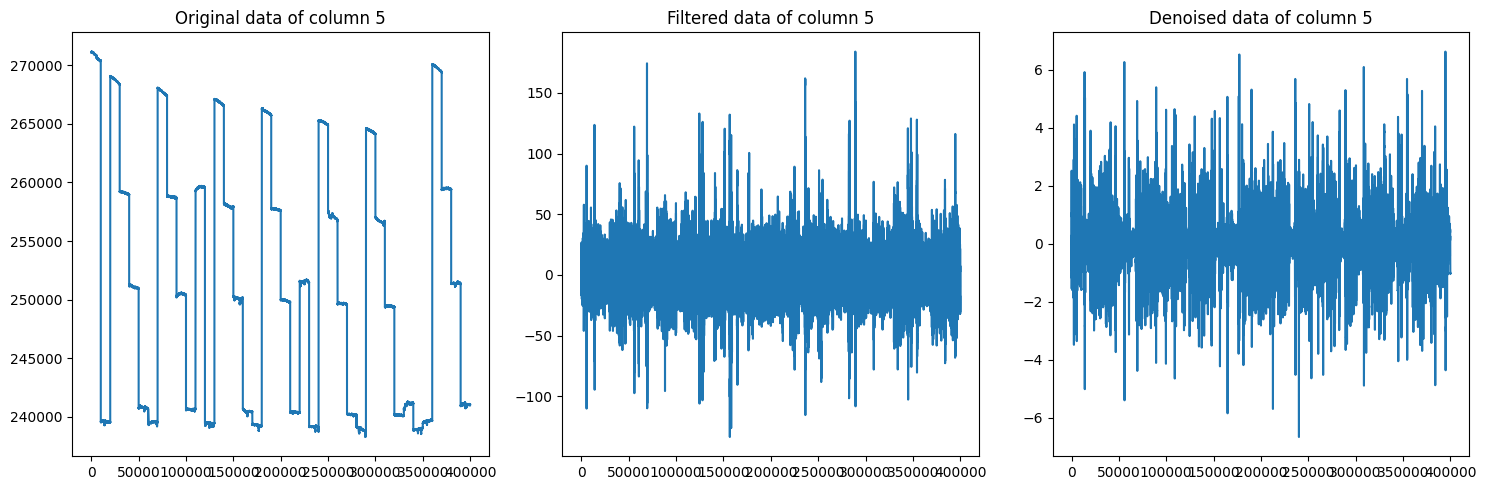

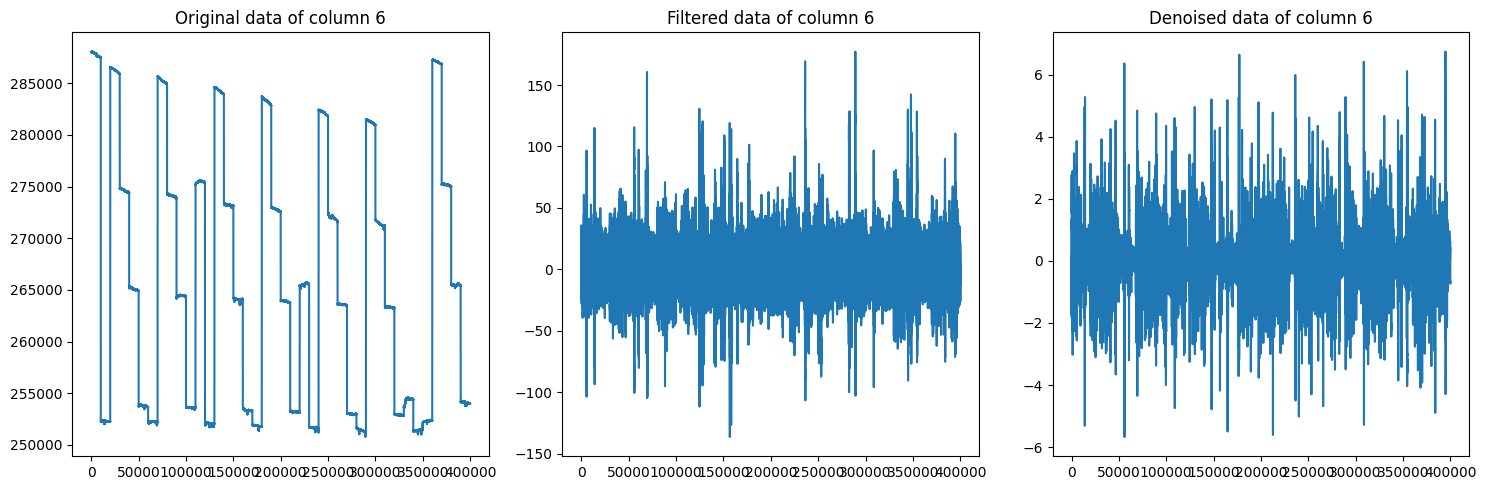

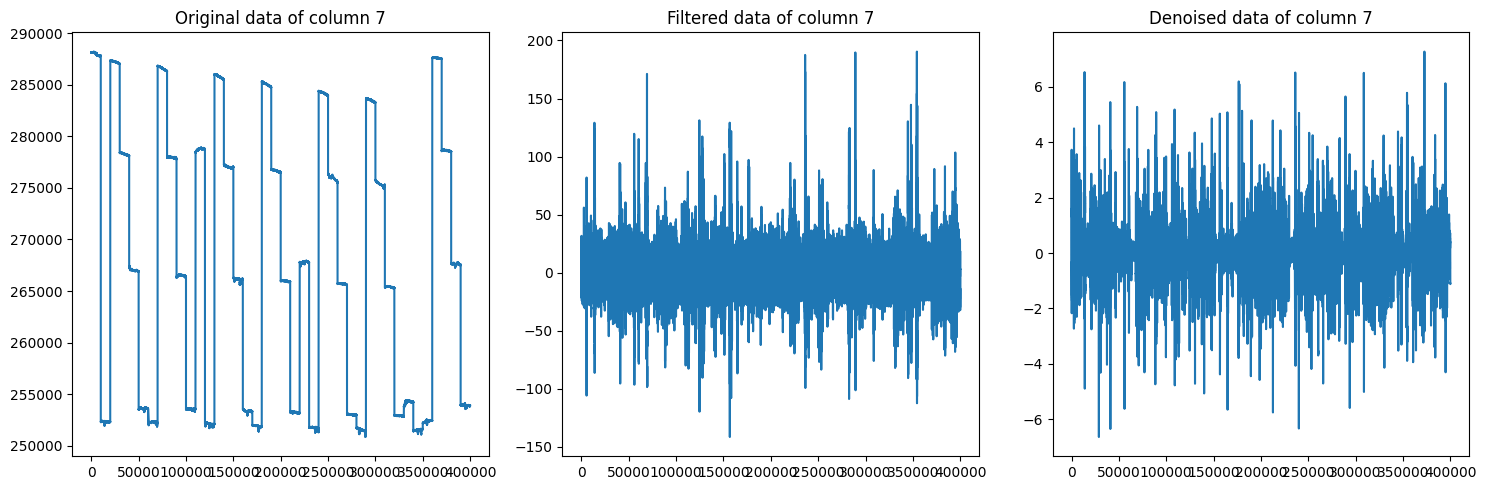

In [24]:
for i in range(8):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Creates a figure with 2 subplots
    axs[0].plot(raw[:,i])
    axs[0].set_title(f'Original data of column {i}')
    axs[1].plot(bandpass[:,i])
    axs[1].set_title(f'Filtered data of column {i}')
    axs[2].plot(denoised[:,i])
    axs[2].set_title(f'Denoised data of column {i}')
    plt.tight_layout()  # Adjusts subplot parameters for better fit
    plt.show() 

In [25]:
face_eeg_dada=face.reshape(20,40,50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)

scene_eeg_dada=scene.reshape(20,40,50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))


(20, 50, 8)
(50, 8)
(20, 50, 8)
(50, 8) <class 'numpy.ndarray'>


In [82]:
fs=250
time_list=[]
for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

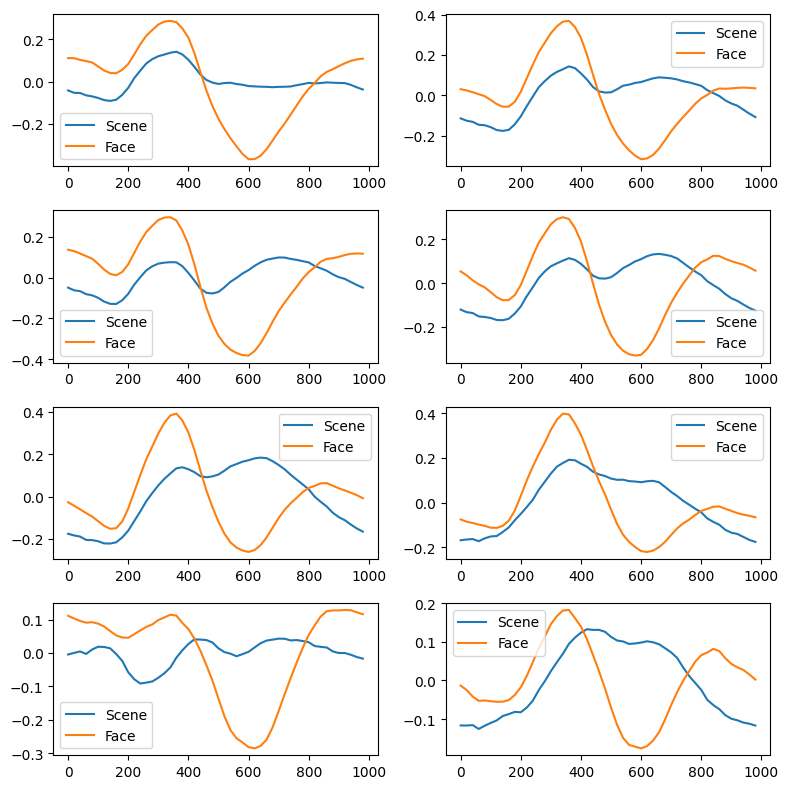

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()


Adding white noise

In [30]:
import numpy as np

min_val_scene = np.min(scene_mean)
max_val_scene = np.max(scene_mean)

min_val_face = np.min(face_mean)
max_val_face = np.max(face_mean)

# Create white noise arrays
noise_before_scene = np.random.uniform(low=min_val_scene, high=max_val_scene, size=(50, 8))
noise_after_scene = np.random.uniform(low=min_val_scene, high=max_val_scene, size=(50, 8))

noise_before_face = np.random.uniform(low=min_val_face, high=max_val_face, size=(50, 8))
noise_after_face = np.random.uniform(low=min_val_face, high=max_val_face, size=(50, 8))

# Concatenate original array with noise
scene_mean_noise = np.concatenate((noise_before_scene,scene_mean, noise_after_scene), axis=0)
face_mean_noise = np.concatenate((noise_before_face,face_mean, noise_after_face), axis=0)

for column in range(scene_mean_noise.shape[1]):
    scene_mean_noise[:, column] = butter_bandpass_filter(scene_mean_noise[:, column], lowcut=.5, highcut=10, fs=250) 
    face_mean_noise[:, column] = butter_bandpass_filter(face_mean_noise[:, column], lowcut=.5, highcut=10, fs=250) 

scene_mean_noise = z_score(pd.DataFrame(scene_mean_noise, columns=selected_columns), col_names=selected_columns)  
scene_mean_noise =np.array(scene_mean_noise ) 
face_mean_noise = z_score(pd.DataFrame(face_mean_noise, columns=selected_columns), col_names=selected_columns)   
face_mean_noise =np.array(face_mean_noise ) 
                

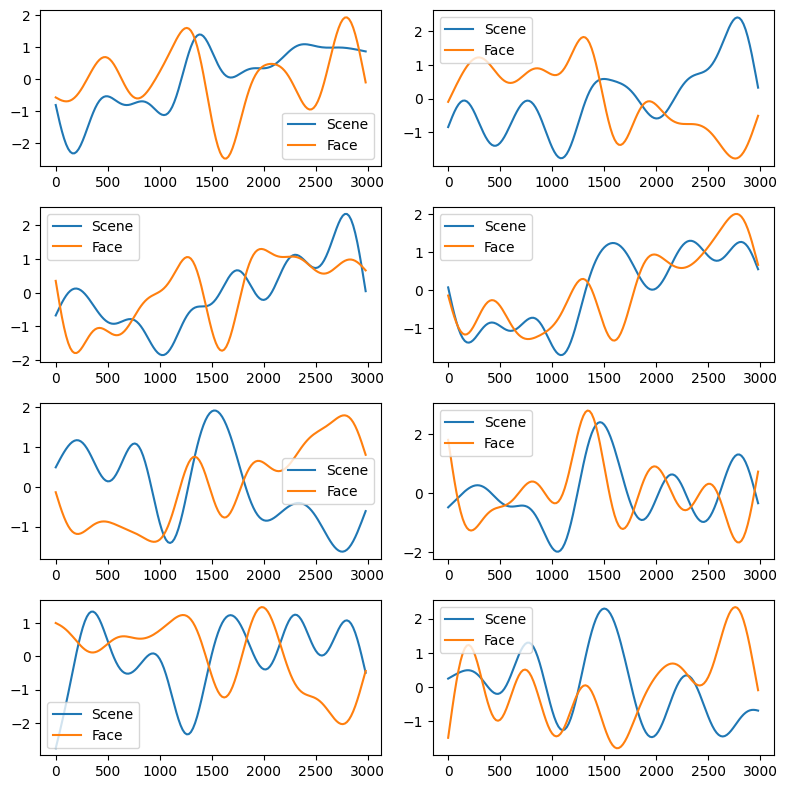

In [79]:
import matplotlib.pyplot as plt

fs=250
time_list=[]
for n in range(face_mean_noise.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

plt.figure(figsize=(8,8))
for channel in range(8):
    plt.subplot(4, 2, channel + 1)  
    plt.plot(time_list, face_mean_noise[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean_noise[:, channel], label=f'Face')
    plt.legend()
plt.tight_layout()
plt.show()


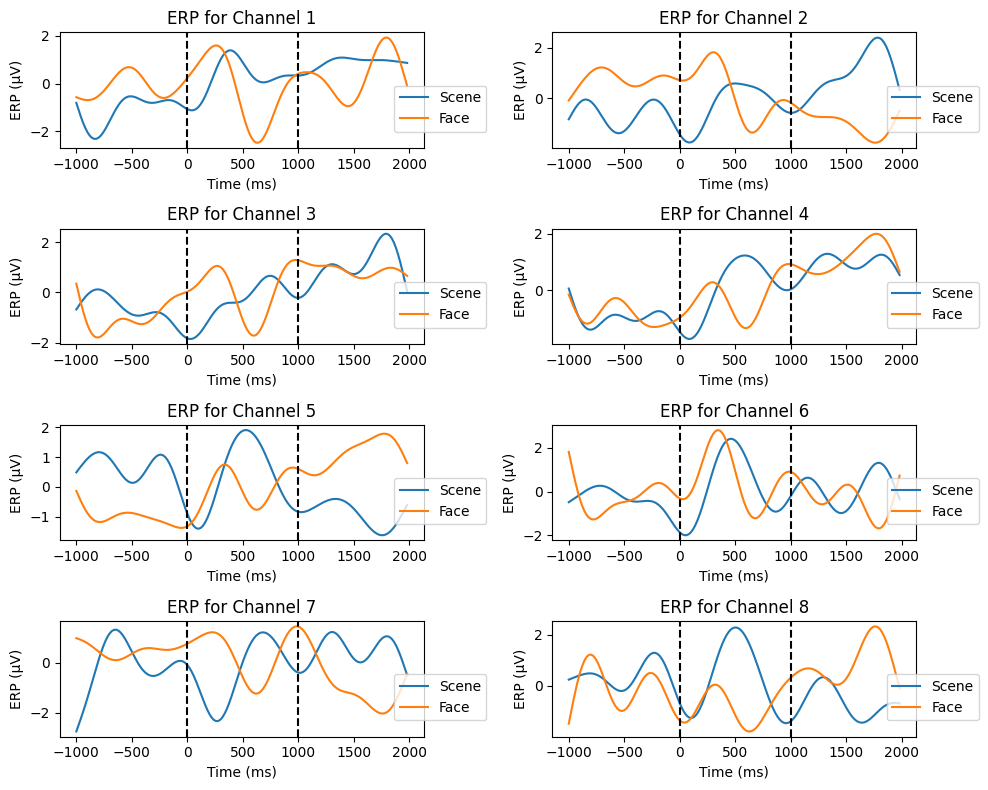

In [78]:
fs=250
shift = 1000  # shifting by 1000 ms (1 second)

time_list=[]
for n in range(face_mean_noise.shape[0]):
    time = ((n * 5) / fs) * 1000 - shift
    time_list.append(time)

plt.figure(figsize=(10,8))  # slightly increased figure size for better spacing
for channel in range(8):
    plt.subplot(4, 2, channel + 1)
    plt.plot(time_list, face_mean_noise[:, channel], label=f'Scene')
    plt.plot(time_list, scene_mean_noise[:, channel], label=f'Face')
    plt.axvline(x=0, color='k', linestyle='--')  # Adds a dashed vertical line at t=0
    plt.axvline(x=1000, color='k', linestyle='--')  # Adds a dashed vertical line at t=1000
    plt.title(f'ERP for Channel {channel + 1}')  # Adds a title for each subplot
    plt.xlabel('Time (ms)')  # Adds an x-axis label
    plt.ylabel('ERP (μV)')  # Adds a y-axis label with unit
    plt.legend(loc='upper left', bbox_to_anchor=(0.90, .6))  # Places the legend outside the plot
plt.tight_layout()
plt.show()



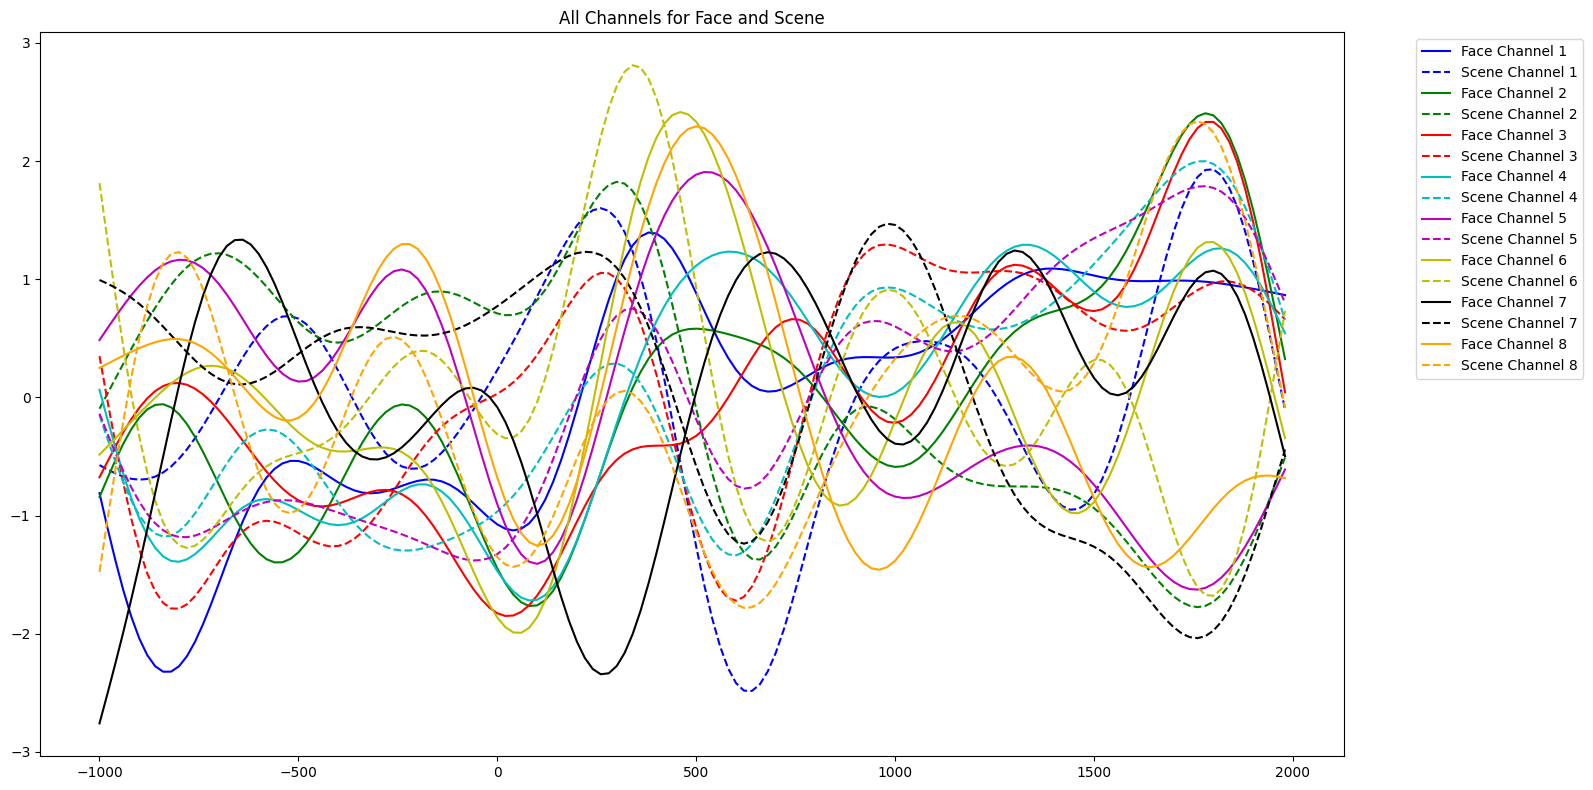

In [73]:
plt.figure(figsize=(16,8))

# Define the color palette for channels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

for channel in range(8):
    # Use different colors for each channel
    plt.plot(time_list, face_mean_noise[:, channel], color=colors[channel], label=f'Face Channel {channel+1}')
    plt.plot(time_list, scene_mean_noise[:, channel], color=colors[channel], linestyle='dashed', label=f'Scene Channel {channel+1}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend box to outside of the plot
plt.title('All Channels for Face and Scene')
plt.tight_layout()
plt.show()


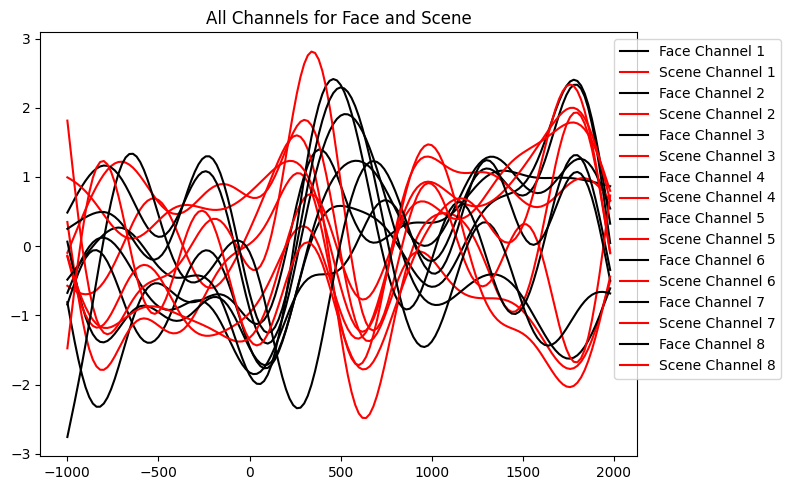

In [76]:
plt.figure(figsize=(8,5))

for channel in range(8):
    # Use 'k' for black for face data, and 'r' for red for scene data
    plt.plot(time_list, face_mean_noise[:, channel], color='k', label=f'Face Channel {channel+1}')
    plt.plot(time_list, scene_mean_noise[:, channel], color='r', label=f'Scene Channel {channel+1}')

plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')  # Move the legend box to outside of the plot
plt.title('All Channels for Face and Scene')
plt.tight_layout()
plt.show()


In [29]:
#event (400000, 1) raw (400000, 8) bandpass (400000, 8) denoised (400000, 8) pp_sig_event (400000, 9) face (200000, 9) scene (200000, 9) labels (400000,)

X=denoised.reshape(1600, 250*8)
labels=labels.reshape(1600, 250)
Y=np.squeeze(labels[:,0])
print(X.shape, Y.shape)

(1600, 2000) (1600,)


Feature Extraction

In [48]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert, welch
from scipy.stats import skew, kurtosis
from numpy import unwrap, diff, abs, angle

# Define bandpass filter
def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Define function to calculate hilbert features
def calculate_hilbert_features(signal, fs):
    analytic_signal = hilbert(signal)
    
    # Calculate amplitude envelope
    amplitude_envelope = abs(analytic_signal)
    
    # Calculate instantaneous phase
    instantaneous_phase = angle(analytic_signal)
    
    # Calculate instantaneous frequency
    unwrapped_phase = unwrap(instantaneous_phase)
    instantaneous_frequency = diff(unwrapped_phase) / (2.0*np.pi) * fs 
    
    return amplitude_envelope, #instantaneous_phase, instantaneous_frequency

# Define function to calculate statistical features
def calculate_statistical_features(signal):
    # Mean
    mean = np.mean(signal)
    
    # Standard deviation
    std = np.std(signal)
    
    # Skewness
    sk = skew(signal)
    
    # Kurtosis
    kurt = kurtosis(signal)
    
    return mean

# Define your sampling frequency
fs = 250

# Define your EEG signal here, assuming it's a 1D NumPy array
eeg_signal = X  # replace with your actual data

# Define frequency bands
frequency_bands = {'delta': (0.5, 4),
                   'theta': (4, 8),
                   'alpha': (8, 12),
                   'beta': (12, 30),
                   'gamma': (30, 100)}


In [74]:
# Initialize an empty list to store the features for all signals
all_features = []

# Process each one-second EEG signal
for i in range(X.shape[0]):
    # Extract the current one-second EEG signal
    eeg_signal = X[i, :].reshape(-1, 250)  # reshaped to (8, 250)

    # Initialize an empty list to store the features for the current signal
    features = []

    # Feature extraction
    for channel_signal in eeg_signal:
        for band, (low, high) in frequency_bands.items():
            filtered_signal = apply_bandpass_filter(channel_signal, low, high, fs)
            amplitude_envelope = calculate_hilbert_features(filtered_signal, fs)
        
            # for feature_name, feature in zip(('amplitude'), 
            #                                  (amplitude_envelope)):
            #     mean= calculate_statistical_features(feature)
                
            #     # Add the extracted features to the list
            #     features.extend([mean])
    
    # Add the features for the current signal to the list of all features
    all_features.append(amplitude_envelope)

# Convert the list of all features to a NumPy array
all_features = np.array(all_features)

print(all_features.shape)

(1600, 1, 250)


In [68]:
all_features=all_features.reshape(1600, 8, 5)
x=X.reshape(1600, 8, 250)
all_feature = np.concatenate([all_features,x], axis=-1)
af=all_feature.reshape(1600, 8*255)

In [72]:
af, Y = shuffle(af, Y)
print(af.shape, Y.shape)


# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(af, Y)
X_resampled= X_resampled.astype(np.float32)
y_resampled = y_resampled.astype(np.int32)

# Split X and y into training and testing sets
X_touched, X_untouch, y_touch, y_untouch = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_touched, y_touch, test_size=0.1, random_state=42)

# Convert y_train and y_test to categorical format for Keras
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_untouch=tf.keras.utils.to_categorical(y_untouch, num_classes=2)


# Convert the data to a numerical type (float)
X_train = X_train.astype(np.float64)
print(X_train.shape)



# Convert one-hot-encoded labels to integer-encoded labels
y_train = np.argmax(y_train, axis=-1)
y_test = np.argmax(y_test, axis=-1)
y_untouch = np.argmax(y_untouch, axis=-1)
print(y_train.shape, y_test.shape)



print('X_train:', X_train.shape, 'y_train:', y_train.shape, 'X_test:', X_test.shape, 'y_test:',
      y_test.shape, 'X_untouch:', X_untouch.shape, 'y_untouch:', y_untouch.shape )

(1600, 2040) (1600,)
(1296, 2040)
(1296,) (144,)
X_train: (1296, 2040) y_train: (1296,) X_test: (144, 2040) y_test: (144,) X_untouch: (160, 2040) y_untouch: (160,)


In [73]:
from sklearn import svm
from joblib import dump
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
# Create a linear SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier
clf.fit(X_train, y_train)
# Save the model to disk
filename = 'C:/Users/tnlab/OneDrive/Documents/GitHub/Neurofeedback-Based-BCI/SVM for Unicorn Data/my_svm_model.joblib'
dump(clf, filename)

# Make predictions on the test set
y_pred = clf.predict(X_test)

print('Model accuracy: ', accuracy_score(y_test, y_pred))
report_svm_matrix = classification_report(y_test, y_pred)
print("Classification Report:")
print(report_svm_matrix)
report_svm = classification_report(y_test, y_pred, output_dict=True)

report_df_svm = pd.DataFrame(report_svm).transpose()
report_df_svm.to_excel(f"svm_classification_report_{folder_name}.xlsx", index=True)

Model accuracy:  0.4166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.49      0.44        68
           1       0.44      0.36      0.39        76

    accuracy                           0.42       144
   macro avg       0.42      0.42      0.42       144
weighted avg       0.42      0.42      0.41       144

